# PSD

PSD for first 10 minutes of recording. We will analyse the first 10 minutes as PSD is stable across time (compared with 40 min).

author: steeve.laquitaine@epfl.ch

**Execution duration:** : 10 mins for 10 min recordings

**Method**:
* Traces as int16, 10 min
* Welch PSD
* Power is energy per time: can be compared between traces of different durations (sample length).

### Setup

1. Activate `spikeinterf..` venv

2. precompute data with: $ sbatch cluster/figures/main/marques/psd_10m_buttw_noise_fitd_raw_welch.sbatch

In [11]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
SFREQ = 3200          # sampling frequency

# welch PSD plots
FILT_WIND_SIZE = 32000 # 1Hz freq. resol
FILT_WIND_OVERLAP = int(
    FILT_WIND_SIZE // 1.5
)
FILT_WINDOW = "hann"


# SETUP DATASET COMFIG
# hybrid
data_conf_sili, param_conf_sili = get_config("buccino_2020", "2020").values()
RAW_PATH_sili = data_conf_sili["probe_wiring"]["output"]
PREP_PATH_sili = data_conf_sili["preprocessing"]["output"]["trace_file_path"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIG_SIZE = (8, 3)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 30
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
N_MAJOR_TICKS = 3
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e8]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-15 14:33:35,735 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-15 14:33:35,751 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Utils

In [26]:
def load_saved_traces_in_ctx():

    raw_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/hybrid/buccino/recording/traces_10m.npy",
    )

    prep_traces_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/dataeng/hybrid/buccino/preprocessed/traces_10m.npy",
    )
    return raw_traces_sili, prep_traces_sili


def load_psd_results():

    # raw
    out_raw_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/raw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_raw_sili = out_raw_sili.item()

    # preprocessed
    out_prep_sili = np.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/postprocessing/hybrid/buccino/realism/lfp/prep_buttw_power_welch_10m.npy",
        allow_pickle=True,
    )
    out_prep_sili = out_prep_sili.item()
    return out_raw_sili, out_prep_sili


def plot_power_for_layer(
    layer: str,
    site_layers_sili: list,
    site_layers_vivo: list,
    out_raw_vivo: dict,
    out_raw_sili: dict,
):
    """plot power spectrum density for the
    specified layer

    Args:
        layer (str): layer "L1", "L2_3", "L4", "L5", "L6"
        site_layers_sili (list): layers of each in silico sites
        site_layers_vivo (list): layers of each in vivo sites
        out_raw_vivo (dict): _description_
        out_raw_sili (dict): _description_
    """

    fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

    # Select traces in layer

    # raw
    raw_power_sili_layer_i = out_raw_sili["power"][site_layers_sili == layer, :]
    raw_power_vivo_layer_i = out_raw_vivo["power"][site_layers_vivo == layer, :]

    # preprocessed
    prep_power_sili_layer_i = out_prep_sili["power"][site_layers_sili == layer, :]
    prep_power_vivo_layer_i = out_prep_vivo["power"][site_layers_vivo == layer, :]

    # Raw panel --------------------------------

    # VIVO
    psd_mean = np.mean(raw_power_vivo_layer_i, axis=0)
    axes[0].plot(
        out_raw_vivo["freq"],
        psd_mean,  # / psd_mean.mean(),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(raw_power_sili_layer_i, axis=0)
    axes[0].plot(
        out_raw_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_xlabel("")
    # axes[0].set_ylabel("Power (ratio)")
    # axes[0].set_yscale("log")
    axes[0].set_xscale("log")
    axes[0].spines[["right", "top"]].set_visible(False)
    axes[0].set_ylim(YLIM_R)
    axes[0].set_xlim([-1, SFREQ_SILICO / 2])
    axes[0].tick_params(axis="x", which="minor", colors="black")
    axes[0].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[0].tick_params(which="both")
    axes[0].xaxis.set_major_locator(locmaj)
    axes[0].xaxis.set_minor_locator(locmin)
    axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[0].tick_params(which="both", width=1)
    # axes[0].xaxis.set_major_locator(locmaj)
    # axes[0].xaxis.set_minor_locator(locmin)
    # axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # Preprocessed panel --------------------------------

    # VIVO
    psd_mean = np.mean(prep_power_vivo_layer_i, axis=0)
    axes[1].plot(
        out_prep_vivo["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_VIVO,
        label="vivo",
    )

    # SILICO
    psd_mean = np.mean(prep_power_sili_layer_i, axis=0)
    axes[1].plot(
        out_prep_sili["freq"],
        psd_mean,  # / np.mean(psd_mean),
        color=COLOR_SILI,
        label="silico",
    )

    # legend
    # axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_xlabel("")
    axes[1].set_xscale("log")
    axes[1].spines[["left", "right", "top"]].set_visible(False)
    axes[1].set_yticklabels([])
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    # axes[1].legend(**legend_cfg)
    axes[1].set_ylim(YLIM_P)

    # # show minor ticks
    # locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    # locmin = matplotlib.ticker.LogLocator(
    #     base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=N_MINOR_TICKS
    # )
    # axes[1].tick_params(which="both", width=1)
    # axes[1].xaxis.set_major_locator(locmaj)
    # axes[1].xaxis.set_minor_locator(locmin)
    # axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    axes[1].set_xlim([-1, SFREQ_SILICO / 2])
    axes[1].tick_params(axis="x", which="minor", colors="black")
    axes[1].tick_params(axis="x", which="major", colors="black")

    # show minor ticks
    locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
    locmin = matplotlib.ticker.LogLocator(
        base=10.0,
        subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        numticks=N_MINOR_TICKS,
    )
    axes[1].tick_params(which="both")
    axes[1].xaxis.set_major_locator(locmaj)
    axes[1].xaxis.set_minor_locator(locmin)
    axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    # axes[0].set_xticklabels([])

    fig.tight_layout(**tight_layout_cfg)
    return axes

### (1s)Load dataset

In [22]:
# Load traces (ok if float32, just to get layers)
# load raw traces
RawSili = si.load_extractor(RAW_PATH_sili)

# load preprocessed tracess
PreprocessedSili = si.load_extractor(PREP_PATH_sili)

# select first 10 minutes
RawSili = RawSili.frame_slice(start_frame=0, end_frame=SFREQ * 10 * 60)
PreprocessedSili = PreprocessedSili.frame_slice(start_frame=0, end_frame=SFREQ * 10 * 6)

#### Load traces and PSD in ctx (1m)

In [27]:
# load traces
raw_traces_sili, prep_traces_sili = load_saved_traces_in_ctx()

# load PSD data
out_raw_sili, out_prep_sili = load_psd_results()

#### (2m) Plot

The PSD is averaged over sites and divided by the total power over frequencies.

In [28]:
# (11s) average over sites
psd_mean_raw_sili = np.mean(out_raw_sili["power"], axis=0)
psd_mean_prep_sili = np.mean(out_prep_sili["power"], axis=0)

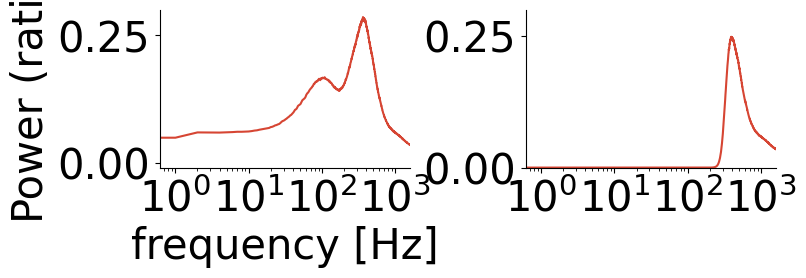

In [34]:
# takes 2 mins
YLIM_R = [-0.01, 0.3]
YLIM_P = [-0.001, 0.3]
N_MAJOR_TICKS = 4

fig, axes = plt.subplots(1, 2, figsize=FIG_SIZE)

# Raw panel (8 secs) --------------------------------

axes[0].plot(
    out_raw_sili["freq"],
    psd_mean_raw_sili,  # / np.mean(psd_mean_raw_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[0].set_xscale("log")
axes[0].set_xlim([-1, SFREQ / 2])
axes[0].set_xlabel("frequency [Hz]")
axes[0].set_ylim(YLIM_R)
axes[0].set_ylabel("Power (ratio)")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].tick_params(axis="x", which="minor", colors="black")
axes[0].tick_params(axis="x", which="major", colors="black")

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[0].tick_params(which="both")
axes[0].xaxis.set_major_locator(locmaj)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# axes[0].set_xticklabels([])

# Preprocessed panel ******************

# SILICO
axes[1].plot(
    out_prep_sili["freq"],
    psd_mean_prep_sili,  # / np.mean(psd_mean_prep_sili),
    color=COLOR_SILI,
    label="silico",
)

# legend
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(**legend_cfg)

# show minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
    numticks=N_MINOR_TICKS,
)
axes[1].tick_params(which="both")
axes[1].xaxis.set_major_locator(locmaj)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axes[1].set_ylim(YLIM_P)
axes[1].set_xlim([-1, SFREQ / 2])

fig.tight_layout(**tight_layout_cfg)

# clear legend
axes[1].get_legend().remove()

# save
plt.savefig(
    "figures/2_realism/4_power/svg/buccino/buccino_10m_psd_raw_welch.svg", **savefig_cfg
)

#### plot layer 1

# references

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
